In [1]:
%load_ext autoreload
%autoreload 2

lscnrs01-fl09-20180730-0020-e91.fits for mjd: 58330.3596906
cptnrs03-fa13-20181122-0038-e91.fits for mjd: 58445.0093943
cptnrs03-fa13-20190603-0031-e91.fits for mjd: 58638.167903
cptnrs03-fa13-20190311-0025-e91.fits for mjd: 58553.7527935
lscnrs01-fl09-20180730-0021-e91.fits for mjd: 58330.3634695
cptnrs03-fa13-20190311-0024-e91.fits for mjd: 58553.7479017
cptnrs03-fa13-20181122-0039-e91.fits for mjd: 58445.0143089
cptnrs03-fa13-20190114-0032-e91.fits for mjd: 58497.8633602
cptnrs03-fa13-20190114-0033-e91.fits for mjd: 58497.8682518
cptnrs03-fa13-20190603-0032-e91.fits for mjd: 58638.1728067
cptnrs03-fl13-20180911-0021-e91.fits for mjd: 58372.8929264
cptnrs03-fl13-20180911-0022-e91.fits for mjd: 58372.8978241
cptnrs03-fl13-20181003-0026-e91.fits for mjd: 58394.8319412
cptnrs03-fl13-20181003-0027-e91.fits for mjd: 58394.8368211
lscnrs01-fa09-20181219-0037-e91.fits for mjd: 58472.1244845
lscnrs01-fa09-20181219-0038-e91.fits for mjd: 58472.1293878
lscnrs01-fl09-20180602-0031-e91.fits for 

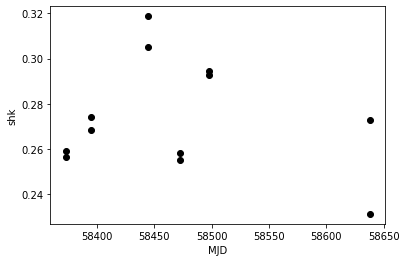

In [3]:
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk

from calc_del_lambda import import_lab_frame_spectra
from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


obsPath = '/home/agoga/Documents/nreshk/data/17051/obs/'
flatsPath = '/home/agoga/Documents/nreshk/data/17051/flats/'


obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        obsDate = mjd_from_hdu(obsHDu1)
        print(obFile + ' for mjd: ' + str(obsDate))
        obsDict.update({obsDate:obsHDu1})
#        print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

res = .01
label =''

lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/',resolution=res*10)



bad = [58330.3596906,58330.3634695,
       58553.7527935,58553.7479017,
       58272.4211262,58272.4248934,
       58354.2323109,58354.2381758]

   

tmpArray = [[],[]]

for oK in obsDict:
    if(oK in bad):
        continue
    fK = closestKey(flatDict,oK)
    
    if abs(oK-fK) > 2:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    ret = mk_flatolap(oHDu[7].data, fHDu[0].data)
    lamGrid = ret[0]
    
    label=str(oK).replace('.','/') + '/'
    
    print('label: ' + label)
    #plt.figure()
    #plt.title('mjd: ' + str(oK))
    
    targOlapf = calc_targOlapf(lamGrid,oHDu[7].data,oHDu[1].data, ret[1],17.)
    print('MJD: ' + str(oK))
    
    
    out = tmp_find_del_lam(lab[0],lab[1], lamGrid, targOlapf,res)
    dLam = out[0]
    
    lamda_zoom(lamGrid, out[2],lamGrid-out[0], out[1],[393.369,396.85,400.525,403.076,404.582,406.36], label ,.3)

    lamRes = 393.369
    
    rv = dLam / lamRes * sc.c
    rv = rv/10000
    print('rv: ' + str(rv))
    shk = calc_shk(lamGrid, targOlapf, rv)
    tmpArray[0].append(mjd_from_hdu(obsDict[oK]))
    tmpArray[1].append(shk)


shkArray = np.asarray(tmpArray)

plt.figure()    
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.xlabel('MJD')
plt.ylabel('shk')
plt.show()